In [1]:
pip install pytorch-tabnet

In [39]:
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             classification_report, roc_auc_score,
                             average_precision_score,precision_recall_curve)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
df = pd.read_csv("/content/drive/MyDrive/Navkalpna modeified/cleaned_cardio_data.csv")

In [42]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'pulse_pressure',
       'pulse_pressure_cat', 'Bmi', 'Bmi_cat', 'age_bp_inter',
       'gluc_bmi_inter', 'simple_risk_index'],
      dtype='object')

In [43]:
df.shape

(50578, 19)

In [44]:
good_features = [
        "ap_hi",
        'cholesterol',
        "pulse_pressure",
        "Bmi_cat",
        "age_bp_inter",
        "gluc_bmi_inter",
        "simple_risk_index",
    ]

In [45]:
X=df[good_features]
y=df['cardio']

- train test split

In [46]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.25)

- categorical and numerical features for scaling and encoding

In [47]:
num_features =X.select_dtypes(include='number').columns.to_list()

cat_features = X.select_dtypes(include='object').columns.to_list()


- added a preprocessor

In [48]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_features)
])

In [49]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

# XGBOOST MODEL

In [12]:
xgb = XGBClassifier(
    n_estimators     = 1200,
    max_depth        = 6,
    learning_rate    = 0.025,
    subsample        = 0.85,
    colsample_bytree = 0.75,
    random_state     = 42,         # slightly help if imbalance bothers you
    eval_metric      = 'auc'
)

In [13]:
Xgb_model=Pipeline([
    ("preprocess", preprocessor),
    ("model", xgb)
])

In [14]:
calibrated_Xgboost = CalibratedClassifierCV(
    estimator=Xgb_model,
    method="isotonic",
    cv=5
)

calibrated_Xgboost.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('preprocess',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   ['ap_hi',
                                                                                    'cholesterol',
                                                                                    'pulse_pressure',
                                                                                    'age_bp_inter',
                                                                                    'gluc_bmi_inter',
                                                                                    'simple_risk_index']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 handle_unknown='ignore'),
                                                                                   ['Bmi_cat'])])),
                                                 ('model',
                                                  XGBClassifier(base_score=None,
                                                                booster=None,
                                                                callb...
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.025,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=6,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=1200,
                                                                n_jobs=None,
                                                                num_parallel_tree=None, ...))]),
                       method='isotonic')

In [15]:
y_pred_Xgb=calibrated_Xgboost.predict(X_test)
y_prob_Xgb=calibrated_Xgboost.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred_Xgb))
print("Recall:", recall_score(y_test, y_pred_Xgb))
print("Precision:", precision_score(y_test, y_pred_Xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_Xgb))
print("PR-AUC:",average_precision_score(y_test, y_prob_Xgb))
print(classification_report(y_test, y_pred_Xgb ))

Accuracy: 0.8936338473705022
Recall: 0.8504320502749411
Precision: 0.9323114019979332
ROC AUC: 0.9716194129920294
PR-AUC: 0.9741849852795496
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6280
           1       0.93      0.85      0.89      6365

    accuracy                           0.89     12645
   macro avg       0.90      0.89      0.89     12645
weighted avg       0.90      0.89      0.89     12645



In [16]:

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_Xgb)
best_threshold = 0.5  # default threshold
for p, r, t in zip(precisions, recalls, thresholds):
    if r > 0.85 and p > 0.88:
        print("Best threshold:", t)
        best_threshold = t
        break

Best threshold: 0.4512666165828705


- after threshold tuning

In [17]:

y_pred_Xgb = (y_prob_Xgb >= best_threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_Xgb))
print("Recall:", recall_score(y_test, y_pred_Xgb))
print("Precision:", precision_score(y_test, y_pred_Xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_Xgb))
print("PR-AUC:",average_precision_score(y_test, y_prob_Xgb))
print(classification_report(y_test, y_pred_Xgb ))

Accuracy: 0.8880980624752867
Recall: 0.9003927729772192
Precision: 0.8800675675675675
ROC AUC: 0.9716194129920294
PR-AUC: 0.9741849852795496
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6280
           1       0.88      0.90      0.89      6365

    accuracy                           0.89     12645
   macro avg       0.89      0.89      0.89     12645
weighted avg       0.89      0.89      0.89     12645



In [18]:
!pip install shap

In [19]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# -------------------------
# DATA
# -------------------------
X = df.drop(columns=["cardio"]).copy()
y = df["cardio"].astype(int)

# make numeric + handle missing safely
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median(numeric_only=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SHAP background sample (important for speed + stability)
bg = X_train.sample(n=min(1000, len(X_train)), random_state=42)

XGBoost ROC-AUC: 0.97212387313016


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


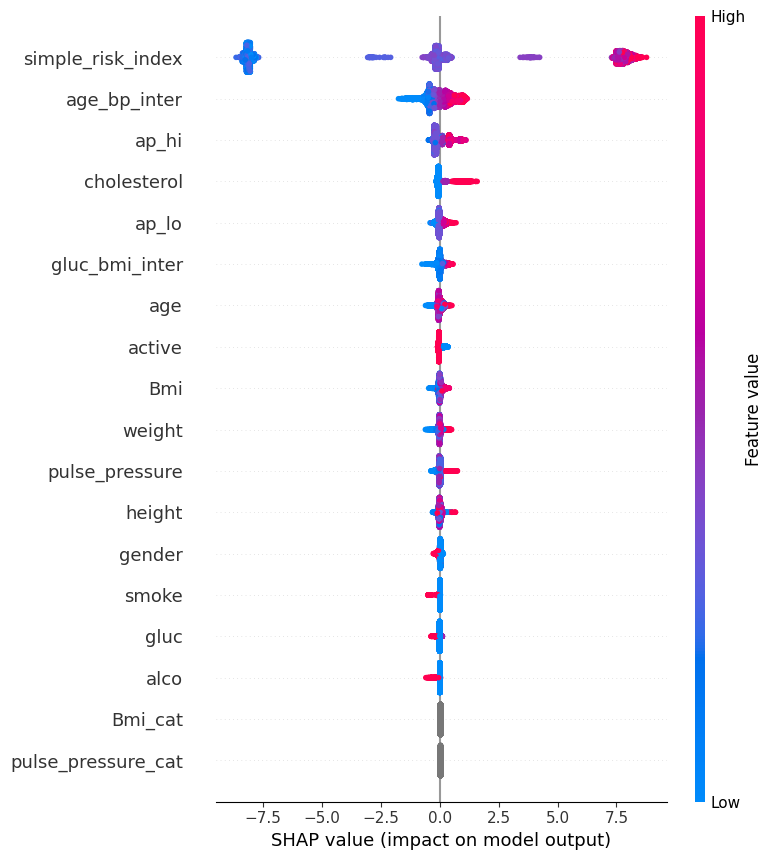

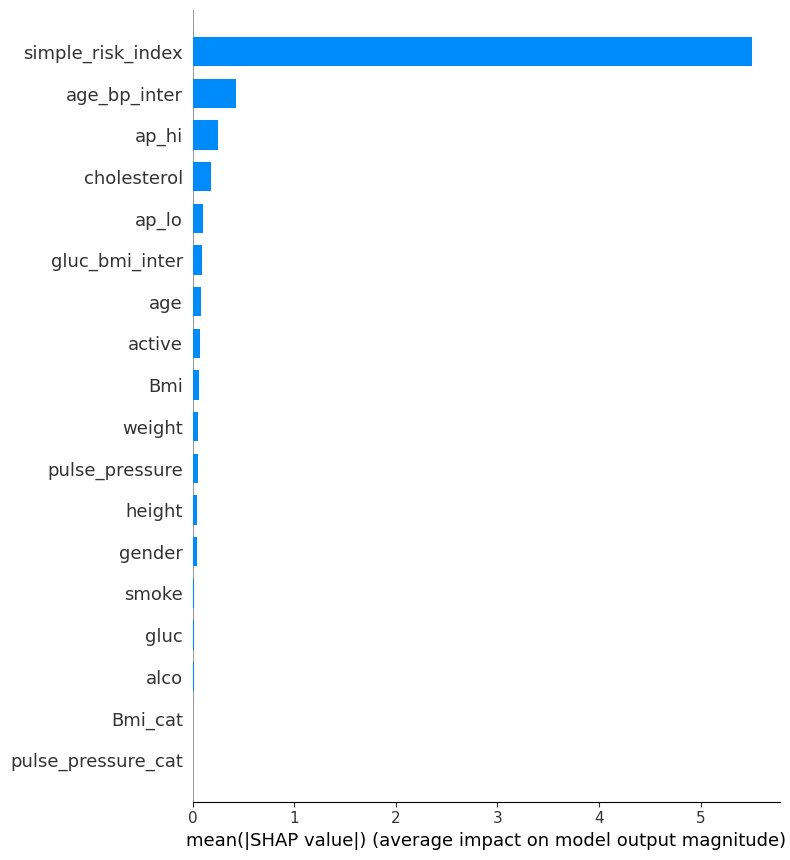

In [20]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, eval_metric="logloss"
)
xgb_model.fit(X_train, y_train)

proba = xgb_model.predict_proba(X_test)[:, 1]
print("XGBoost ROC-AUC:", roc_auc_score(y_test, proba))

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)              # beeswarm
shap.summary_plot(shap_values, X_test, plot_type="bar")

# LightGBM MODEL

In [21]:
lgbm = LGBMClassifier(
    learning_rate=0.05, n_estimators=1200,
    random_state=42,class_weight="balanced"
)

In [22]:
LGBM_model=Pipeline([
    ("preprocess", preprocessor),
    ("model", lgbm)
])

In [23]:
calibrated_lgbm = CalibratedClassifierCV(
    estimator=LGBM_model,
    method="isotonic",
    cv=5
)
calibrated_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 16482, number of negative: 15887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 32369, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 16482, number of negative: 15887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 32369, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 16482, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 32370, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 16483, number of negative: 15887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 32370, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 16483, number of negative: 15887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 32370, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('preprocess',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   ['ap_hi',
                                                                                    'cholesterol',
                                                                                    'pulse_pressure',
                                                                                    'age_bp_inter',
                                                                                    'gluc_bmi_inter',
                                                                                    'simple_risk_index']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 handle_unknown='ignore'),
                                                                                   ['Bmi_cat'])])),
                                                 ('model',
                                                  LGBMClassifier(class_weight='balanced',
                                                                 learning_rate=0.05,
                                                                 n_estimators=1200,
                                                                 random_state=42))]),
                       method='isotonic')

In [24]:
y_pred_lgbm=calibrated_lgbm.predict(X_test)
y_prob_lgbm=calibrated_lgbm.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("Recall:", recall_score(y_test, y_pred_lgbm))
print("Precision:", precision_score(y_test, y_pred_lgbm))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lgbm))
print(classification_report(y_test, y_pred_lgbm ))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

Accuracy: 0.8862198497429814
Recall: 0.8456610366919045
Precision: 0.9244482173174873
ROC AUC: 0.9685429730106475
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4965
           1       0.92      0.85      0.88      5151

    accuracy                           0.89     10116
   macro avg       0.89      0.89      0.89     10116
weighted avg       0.89      0.89      0.89     10116



In [25]:

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_lgbm)
best_threshold = 0.5  # default threshold
for p, r, t in zip(precisions, recalls, thresholds):
    if r > 0.85 and p > 0.88:
        print("Best threshold:", t)
        best_threshold = t
        break

Best threshold: 0.45371849724342245


- after threshold tuning

In [26]:

y_pred_lgbm = (y_prob_lgbm >= best_threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("Recall:", recall_score(y_test, y_pred_lgbm))
print("Precision:", precision_score(y_test, y_pred_lgbm))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lgbm))
print("PR-AUC:",average_precision_score(y_test, y_prob_lgbm))
print(classification_report(y_test, y_pred_lgbm ))

Accuracy: 0.8831553973902728
Recall: 0.8920597942147156
Precision: 0.8800995977782035
ROC AUC: 0.9685429730106475
PR-AUC: 0.9720097223530293
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4965
           1       0.88      0.89      0.89      5151

    accuracy                           0.88     10116
   macro avg       0.88      0.88      0.88     10116
weighted avg       0.88      0.88      0.88     10116



[LightGBM] [Info] Number of positive: 20603, number of negative: 19859
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 40462, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509194 -> initscore=0.036779
[LightGBM] [Info] Start training from score 0.036779
LightGBM ROC-AUC: 0.971388224658613


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


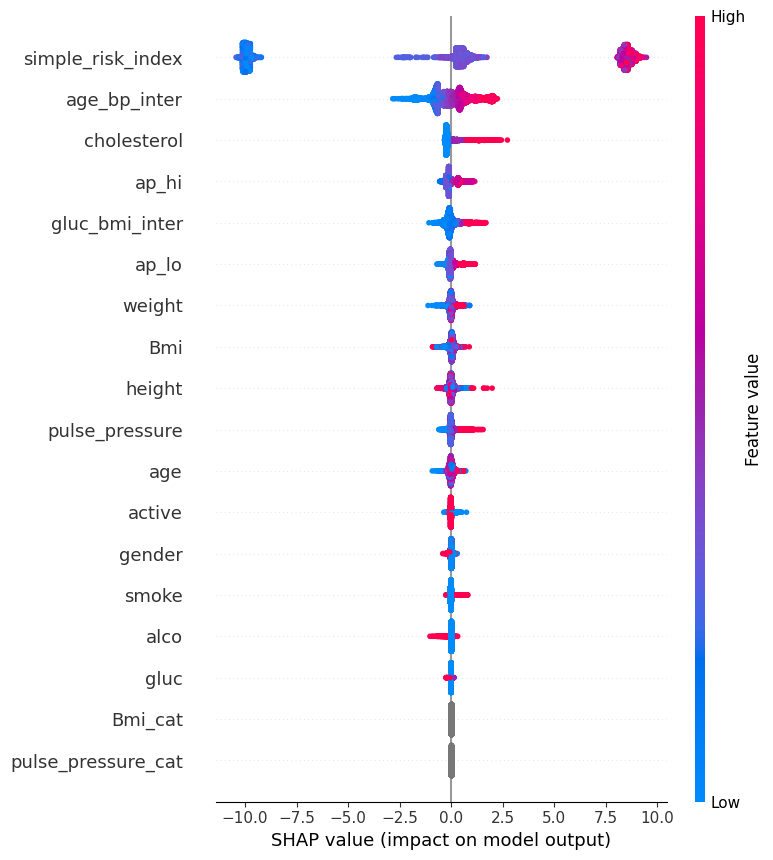

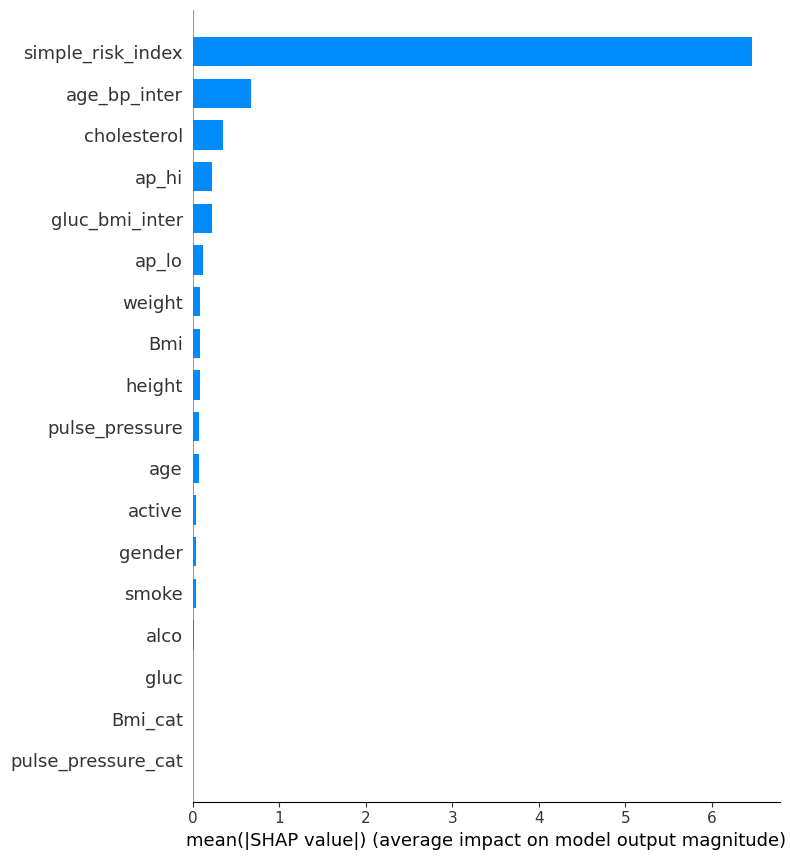

In [27]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=800, learning_rate=0.03,
    num_leaves=31, subsample=0.8, colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(X_train, y_train)

proba = lgb_model.predict_proba(X_test)[:, 1]
print("LightGBM ROC-AUC:", roc_auc_score(y_test, proba))

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# For binary classification, some versions return list [class0, class1]
if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Neural Network

In [50]:
X_train_np = X_train_processed.values if hasattr(X_train_processed, "values") else X_train_processed
X_test_np = X_test_processed.values if hasattr(X_test_processed, "values") else X_test_processed

y_train_np = y_train.values if hasattr(y_train, "values") else y_train
y_test_np = y_test.values if hasattr(y_test, "values") else y_test

In [51]:
# Initialize TabNet
tabnet = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax',
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [30]:
# tabnet_model=Pipeline([
#     ("preprocess", preprocessor),
#     ("model", tabnet)
# ])

In [52]:
# Train
tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_name=['test'],
    eval_metric=['auc'],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)

epoch 0  | loss: 0.26605 | test_auc: 0.96542 |  0:00:09s
epoch 1  | loss: 0.23104 | test_auc: 0.96774 |  0:00:16s
epoch 2  | loss: 0.22993 | test_auc: 0.96746 |  0:00:21s
epoch 3  | loss: 0.22626 | test_auc: 0.96864 |  0:00:28s
epoch 4  | loss: 0.22026 | test_auc: 0.96963 |  0:00:34s
epoch 5  | loss: 0.21786 | test_auc: 0.96851 |  0:00:40s
epoch 6  | loss: 0.2204  | test_auc: 0.96944 |  0:00:46s
epoch 7  | loss: 0.21676 | test_auc: 0.96979 |  0:00:52s
epoch 8  | loss: 0.21884 | test_auc: 0.96972 |  0:00:59s
epoch 9  | loss: 0.21843 | test_auc: 0.96985 |  0:01:05s
epoch 10 | loss: 0.21882 | test_auc: 0.96927 |  0:01:12s
epoch 11 | loss: 0.21668 | test_auc: 0.96933 |  0:01:17s
epoch 12 | loss: 0.21496 | test_auc: 0.96964 |  0:01:24s
epoch 13 | loss: 0.21615 | test_auc: 0.96933 |  0:01:30s
epoch 14 | loss: 0.21369 | test_auc: 0.96982 |  0:01:36s
epoch 15 | loss: 0.21574 | test_auc: 0.96936 |  0:01:43s
epoch 16 | loss: 0.21698 | test_auc: 0.96954 |  0:01:51s
epoch 17 | loss: 0.21116 | test

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [53]:
# Predict
y_pred = tabnet.predict(X_test_np)
y_proba = tabnet.predict_proba(X_test_np)[:, 1]

In [54]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print(classification_report(y_test, y_pred))

Accuracy: 0.891419533412416
Recall: 0.8482325216025137
Precision: 0.929900103341371
ROC AUC: 0.970170130740865
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6280
           1       0.93      0.85      0.89      6365

    accuracy                           0.89     12645
   macro avg       0.89      0.89      0.89     12645
weighted avg       0.89      0.89      0.89     12645



In [55]:

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
best_threshold = 0.5  # default threshold
for p, r, t in zip(precisions, recalls, thresholds):
    if r > 0.85 and p > 0.88:
        print("Best threshold:", t)
        best_threshold = t
        break

Best threshold: 0.4383365


- after threshold tuning

In [56]:

y_pred = (y_proba >= best_threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:",average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Accuracy: 0.8863582443653618
Recall: 0.8961508248232521
Precision: 0.8802469135802469
ROC AUC: 0.970170130740865
PR-AUC: 0.9729499089860215
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      6280
           1       0.88      0.90      0.89      6365

    accuracy                           0.89     12645
   macro avg       0.89      0.89      0.89     12645
weighted avg       0.89      0.89      0.89     12645



# Ensemble model


In [57]:
xgb = XGBClassifier(
        n_estimators=1400,
        max_depth=6,
        learning_rate=0.025,
        subsample=0.85,
        colsample_bytree=0.75,
        min_child_weight=4,
        gamma=0.8,
        reg_lambda=1.2,
        random_state=42,
        eval_metric="aucpr",
        n_jobs=-1,
    )

lgbm = LGBMClassifier(
        n_estimators=1400,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )


stack = StackingClassifier(
        estimators=[("xgb", xgb), ("lgbm", lgbm)],
        final_estimator=LogisticRegression(max_iter=2000, C=0.5),
        stack_method="predict_proba",
        passthrough=True,
        n_jobs=-1,
    )

stack_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", stack)
])

calibrated_stack = CalibratedClassifierCV(
    estimator=stack_pipe,
    method="isotonic",
    cv=5
)

calibrated_stack.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('preprocess',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   ['ap_hi',
                                                                                    'cholesterol',
                                                                                    'pulse_pressure',
                                                                                    'age_bp_inter',
                                                                                    'gluc_bmi_inter',
                                                                                    'simple_risk_index']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 handle_unknown='ignore'),
                                                                                   ['Bmi_cat'])])),
                                                 ('model',
                                                  StackingClassifier(estimators=[('xgb',
                                                                                  XGBClassif...
                                                                                                monotone_constraints=None,
                                                                                                multi_strategy=None,
                                                                                                n_estimators=1400,
                                                                                                n_jobs=-1,
                                                                                                num_parallel_tree=None, ...)),
                                                                                 ('lgbm',
                                                                                  LGBMClassifier(colsample_bytree=0.8,
                                                                                                 learning_rate=0.05,
                                                                                                 n_estimators=1400,
                                                                                                 n_jobs=-1,
                                                                                                 random_state=42,
                                                                                                 subsample=0.85))],
                                                                     final_estimator=LogisticRegression(C=0.5,
                                                                                                        max_iter=2000),
                                                                     n_jobs=-1,
                                                                     passthrough=True,
                                                                     stack_method='predict_proba'))]),
                       method='isotonic')

In [59]:
y_pred_st=calibrated_stack.predict(X_test)
y_prob_st=calibrated_stack.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred_st))
print("Recall:", recall_score(y_test, y_pred_st))
print("Precision:", precision_score(y_test, y_pred_st))
print("ROC AUC:", roc_auc_score(y_test, y_prob_st))
print(classification_report(y_test, y_pred_st))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

Accuracy: 0.892526690391459
Recall: 0.8617439120188531
Precision: 0.9196847753185782
ROC AUC: 0.9707916126708062
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6280
           1       0.92      0.86      0.89      6365

    accuracy                           0.89     12645
   macro avg       0.89      0.89      0.89     12645
weighted avg       0.89      0.89      0.89     12645



In [60]:

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_st)
best_threshold = 0.5  # default threshold
for p, r, t in zip(precisions, recalls, thresholds):
    if r > 0.85 and p > 0.88:
        print("Best threshold:", t)
        best_threshold = t
        break

Best threshold: 0.44993052622053764


- after threshold tuning

In [61]:

y_pred_Xgb = (y_prob_st >= best_threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_Xgb))
print("Recall:", recall_score(y_test, y_pred_Xgb))
print("Precision:", precision_score(y_test, y_pred_Xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_st))
print("PR-AUC:",average_precision_score(y_test, y_prob_st))
print(classification_report(y_test, y_pred_st ))

Accuracy: 0.8869909054962436
Recall: 0.8975648075412411
Precision: 0.8802773497688752
ROC AUC: 0.9707916126708062
PR-AUC: 0.9731368782448032
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6280
           1       0.92      0.86      0.89      6365

    accuracy                           0.89     12645
   macro avg       0.89      0.89      0.89     12645
weighted avg       0.89      0.89      0.89     12645



In [ ]:
import joblib

In [ ]:
with open('xgb.pkl','wb') as file:
  joblib.dump(calibrated_Xgboost,file)

In [ ]:
with open('lightbgm.pkl','wb') as file1:
  joblib.dump(calibrated_lgbm,file1)

In [ ]:
with open('tabnet.pkl','wb') as file2:
  joblib.dump(tabnet,file2)

In [ ]:
with open('stack.pkl','wb') as file3:
  joblib.dump(calibrated_stack,file3)

In [ ]:
joblib.dump(preprocessor, "preprocessor.pkl")